Dos gráficas distintas: densidad de población y densidad de población inmigrante (no porcentaje, misma escala)

Gráfica temporal para algún barrio: curvas de densidad de población y de población inmigrante: ver si se juntan o se separan

Bivariante: grupos dominantes y densidad de inmigrantes

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color                        # NOTE: additional package generativepy is required (pip)
from PIL import ImageColor

img_dir = './img/bivariate_maps/'
if not exists(img_dir):
    makedirs(img_dir)


# 1. Functions

## 1.1. Prepare DataFrames

In [28]:
def read_data(year):
    data_dir = '../data/birthPlace_spain_v_outside/'
    file_extension = '_birthPlace_spain_v_outside.csv'
    file = str(year) + file_extension

    df = pd.read_csv(data_dir + file)
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    df['Birth_Place'] = df['Birth_Place'].astype(str).str.strip()   # convert to str and strip spaces

    df = df.groupby(['District', 'Birth_Place'], as_index=False)['Value'].sum()

    return df

def compute_total(df):
    # separate spain vs outside spain
    spain = df[df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby('District', as_index=False)['Value'].sum().rename(columns={'Value':'Population_Spain'})

    outside_spain = df[~df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby('District', as_index=False)['Value'].sum().rename(columns={'Value':'Population_outside_Spain'})    # also accounts for 'Not available'

    # merge into single dataframe
    spain_vs_outside = pd.merge(spain, outside_spain, on='District', how='outer').fillna(0)

    spain_vs_outside['Total_population'] = spain_vs_outside['Population_Spain'] + spain_vs_outside['Population_outside_Spain']
    spain_vs_outside['Percent_Spain'] = (spain_vs_outside['Population_Spain'] / spain_vs_outside['Total_population'] * 100).round(2)
    spain_vs_outside['Percent_outside_Spain'] = (spain_vs_outside['Population_outside_Spain'] / spain_vs_outside['Total_population'] * 100).round(2)

    return spain_vs_outside

def merge_geometry(spain_vs_outside):
    geometry_file = '../data/geometry/districts_geometry.csv'

    geometry_df = gpd.read_file(geometry_file)
    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

    gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs="EPSG:25831")
    gdf['Area'] = gdf['Geometry_etrs89'].area / 1e6  # area in square kilometers

    plot_df = pd.merge(gdf, spain_vs_outside, left_on='District', right_on='District', how='left')
    plot_df['Density'] = (plot_df['Total_population'] / plot_df['Area']).round(2)  # population density per square kilometer

    return plot_df

def prepare_gdf(year):
    df = read_data(year)
    spain_vs_outside = compute_total(df)
    gdf = merge_geometry(spain_vs_outside)

    return gdf


## 1.2. Plots

In [29]:
def plot_immigration(year, ax):
    gdf = prepare_gdf(year)

    gdf.plot(column='Percent_outside_Spain', ax=ax, cmap='OrRd', vmin=0, vmax=100, legend=True, legend_kwds={'label': 'Percentage of Population from outside Spain', 'orientation': 'vertical', 'fraction':0.046, 'pad':0.04})
    ax.axis('off')
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def plot_density(year, ax):
    gdf = prepare_gdf(year)

    gdf.plot(column='Density', ax=ax, cmap='OrRd', vmin=6000, vmax=34000, legend=True, legend_kwds={'label': 'Population Density per km$^2$', 'orientation': 'vertical', 'fraction':0.046, 'pad':0.04})
    ax.axis('off')
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def hex_to_Color(hexcode):
    'convert hex color to Color object'
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v / 256 for v in rgb]

    return Color(*rgb)

def plot_bivariate(year, ax,
                   density_min=5000, density_max=38000,
                   immigr_min=0, immigr_max=70,
                   n_bins=5):

    # --- LOAD & BUILD GDF ---
    gdf = prepare_gdf(year)

    # --- BINNING ---
    # fixed bin edges
    density_bins = np.linspace(density_min, density_max, n_bins+1)
    immigr_bins  = np.linspace(immigr_min, immigr_max, n_bins+1)

    # binning
    gdf['density_bin'] = np.digitize(gdf['Density'], density_bins) - 1
    gdf['immigr_bin']  = np.digitize(gdf['Percent_outside_Spain'], immigr_bins) - 1

    # clip to valid indices
    gdf['density_bin'] = gdf['density_bin'].clip(0, n_bins-1)
    gdf['immigr_bin']  = gdf['immigr_bin'].clip(0, n_bins-1)

    # --- GENERATE COLOR MATRIX ---
    # corner colors
    c00 = hex_to_Color('#f3f3f3')
    c10 = hex_to_Color('#e1a800')
    c01 = hex_to_Color('#8997c4')
    c11 = hex_to_Color('#000000')

    # interpolation grid
    color_matrix = []
    for i in range(n_bins):
        row = []
        for j in range(n_bins):
            # i = immigration axis, j = density axis
            col_low = c00.lerp(c10, j/(n_bins-1))
            col_high = c01.lerp(c11, j/(n_bins-1))
            col_final = col_low.lerp(col_high, i/(n_bins-1))
            row.append(rgb2hex([col_final.r, col_final.g, col_final.b]))
        color_matrix.append(row)

    # --- ASSIGN COLORS ---
    gdf['Color'] = [color_matrix[im_bin][dens_bin] for im_bin, dens_bin in zip(gdf['immigr_bin'], gdf['density_bin'])]

    # --- PLOT MAP ---
    gdf.plot(ax=ax, color=gdf["Color"])
    gdf.boundary.plot(ax=ax, color="black", linewidth=0.4)
    ax.axis("off")

    # --- LEGEND AS MATRIX ---
    leg_ax = ax.inset_axes([0.75, 0.05, 0.22, 0.22])
    leg_ax.set_aspect("equal")

    for i in range(n_bins):
        for j in range(n_bins):
            rect = Rectangle((j, i), 1, 1)
            pc = PatchCollection([rect], facecolor=color_matrix[i][j])
            leg_ax.add_collection(pc)

    leg_ax.set_xlim(0, n_bins)
    leg_ax.set_ylim(0, n_bins)
    leg_ax.set_xticks(np.arange(n_bins+1))
    leg_ax.set_yticks(np.arange(n_bins+1))

    # label with actual values
    leg_ax.set_xticklabels([f"{v:.0f}" for v in density_bins])
    leg_ax.set_yticklabels([f"{v:.0f}%" for v in immigr_bins])

    leg_ax.set_xlabel("Density")
    leg_ax.set_ylabel("Immigration (%)")
    leg_ax.tick_params(labelsize=6)

    # --- SCATTER POINTS ON LEGEND ---
    scatter_ax = leg_ax.inset_axes([0, 0, 1, 1], zorder=10)
    scatter_ax.set_xlim(0, n_bins)
    scatter_ax.set_ylim(0, n_bins)
    scatter_ax.set_xticks([])
    scatter_ax.set_yticks([])

    # normalized position of each district (not bin center) - accurate scatters
    norm_dens = (gdf['Density'] - density_min) / (density_max-density_min) * n_bins
    norm_imm  = (gdf['Percent_outside_Spain'] - immigr_min) / (immigr_max-immigr_min) * n_bins

    scatter_ax.scatter(norm_dens, norm_imm, color='r', s=12, marker='x', alpha=0.9)
    
    # transparent background so the legend shows through the scatter points
    scatter_ax.set_facecolor((1,1,1,0))   

    return


# 2. Plots

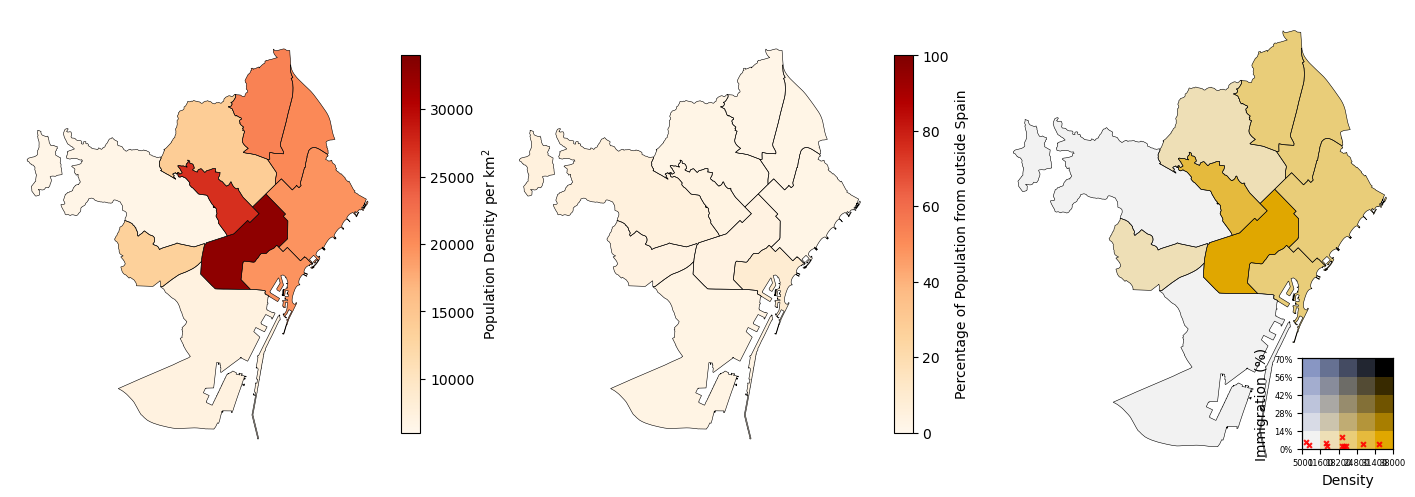

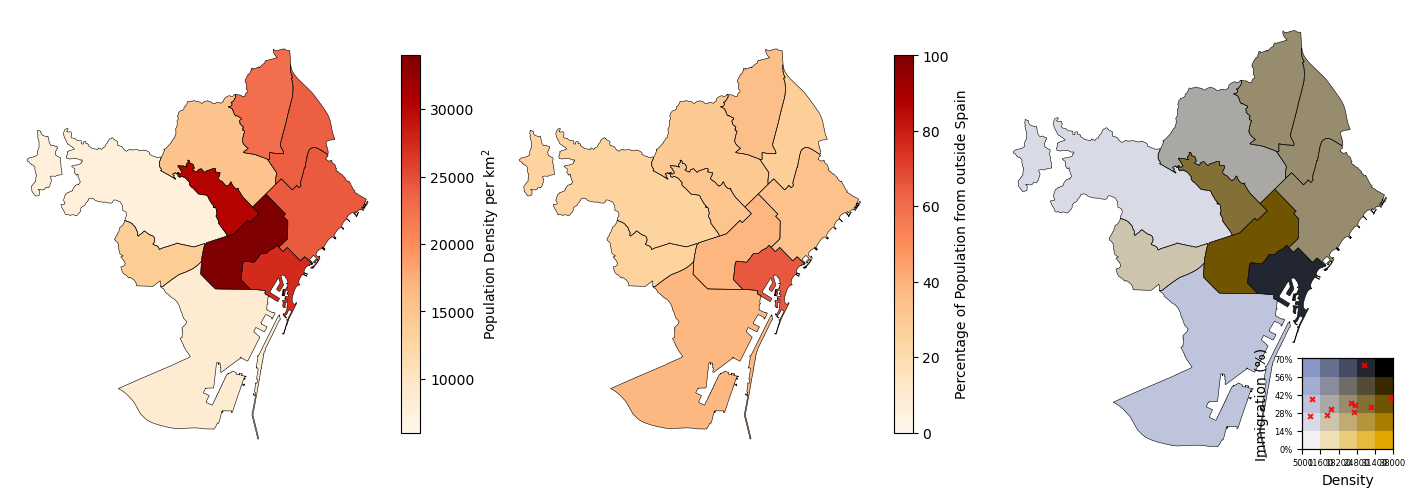

In [30]:
years = [1997, 2025]

for year in years:
    fig, ax = plt.subplots(1, 3, figsize=(18, 12))

    plot_density(year, ax[0])
    plot_immigration(year, ax[1])
    plot_bivariate(year, ax[2])

    # plt.savefig(img_dir + 'bivariate_map_' + str(year) + '.png', dpi=300, bbox_inches='tight')

    plt.show()


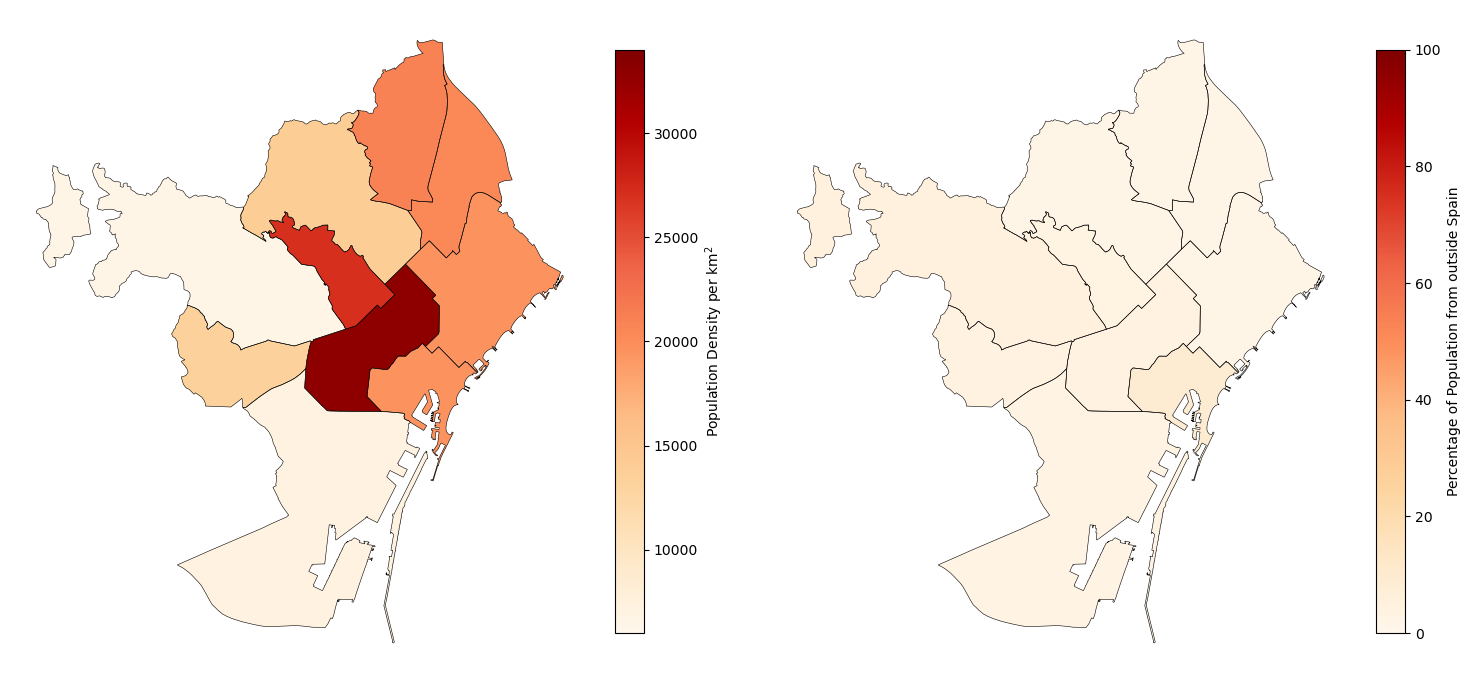

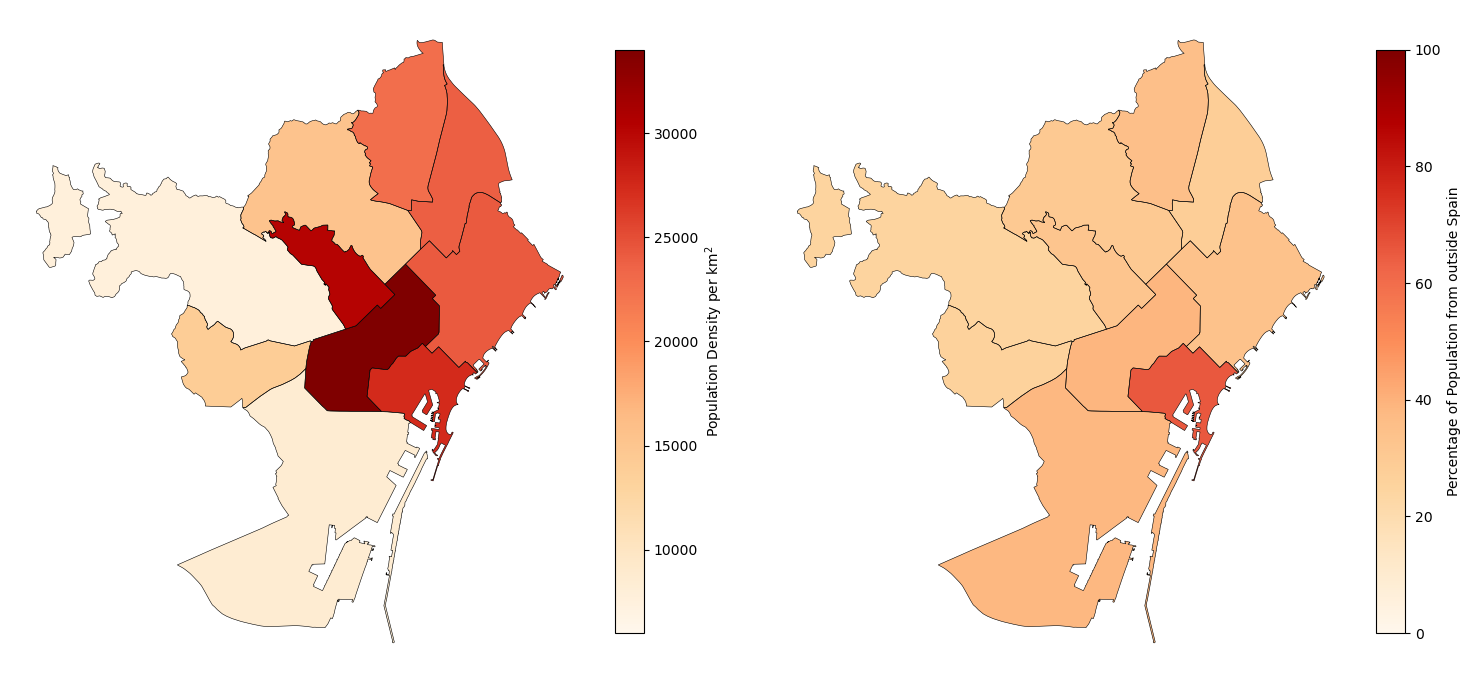

In [32]:
years = [1997, 2025]

for year in years:
    fig, ax = plt.subplots(1, 2, figsize=(18, 12))

    plot_density(year, ax[0])
    plot_immigration(year, ax[1])

    # plt.savefig(img_dir + 'bivariate_map_' + str(year) + '.png', dpi=300, bbox_inches='tight')

    plt.show()


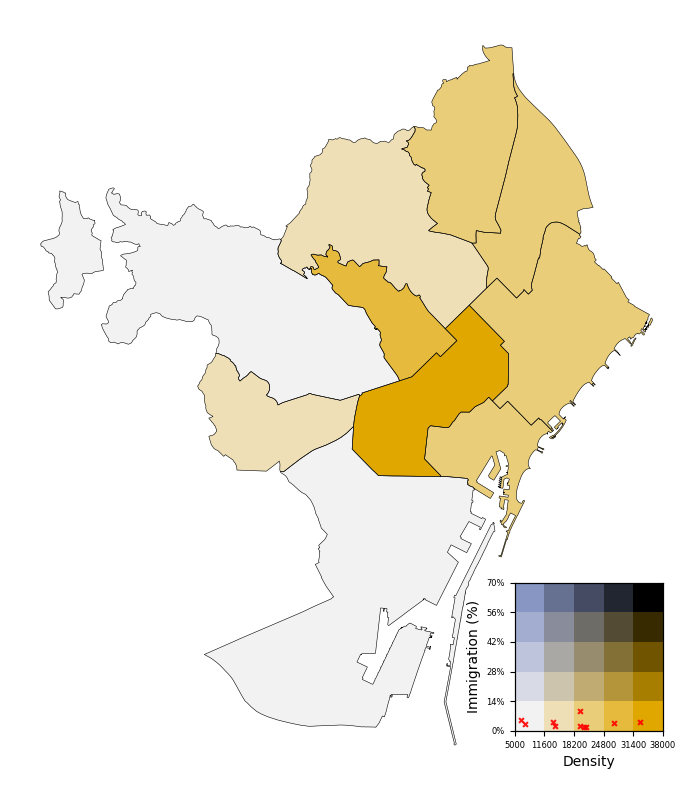

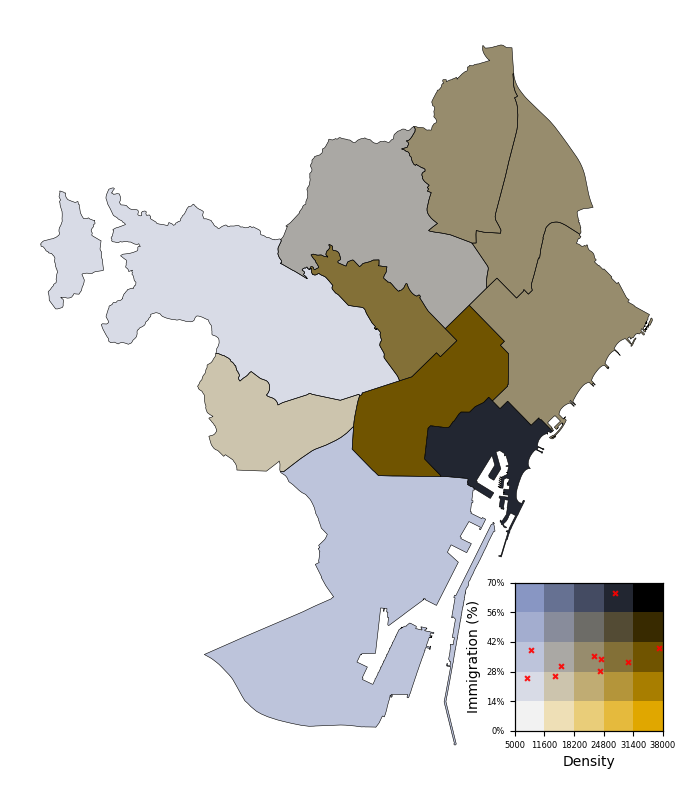

In [31]:
years = [1997, 2025]

for year in years:
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_bivariate(year, ax)
    
    plt.savefig(img_dir + 'bivariate_districts_map_' + str(year) + '.png', dpi=300, bbox_inches='tight')

    plt.show()


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1